# Landcover Evaluation Results

## Initialisation

In [1]:
import json
import numpy as np
import os
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from matplotlib.legend import Legend
from matplotlib.container import BarContainer

import initialise
import common
from analysis_utils import calc_statistics
from display_utils import display_frames

In [2]:
SCENARIOS = ['within-site', 'out-of-site']
DISPLAY_NAMES = [' '.join([s.capitalize(), 'Models']) for s in SCENARIOS]
samples_file = os.path.join(common.DATASETS_DIR, 'samples_365days.csv')
model_dir1 = os.path.join(common.MODELS_DIR, f'{SCENARIOS[0]}_models')
model_dir2 = os.path.join(common.MODELS_DIR, f'{SCENARIOS[1]}_models')
output_dir = common.FIGURES_DIR

In [3]:
WITHIN_SITE_RMSE = 20.9
OUT_OF_SITE_RMSE = 25.4
WITHIN_SITE_R2 = 0.70
OUT_OF_SITE_R2 = 0.54
TEXT_SIZE = 7
FONT_SIZE = 8
TITLE_SIZE = 10
MARKER_SIZE = 7
LINE_WIDTH = 1
SATURATION = 0.6

In [4]:
model = common.ANALYSIS_MODEL
ensemble_size = common.ENSEMBLE_SIZE
ensemble_runs = common.ENSEMBLE_RUNS

### Load Samples and Predictions

In [5]:
with open(os.path.join(model_dir1, 'model_params.json'), 'r') as f:
    ws_params = json.load(f)
all_samples = pd.read_csv(samples_file, index_col=0)
predict2 = pd.read_csv(os.path.join(model_dir2, f'ensemble{ensemble_size}_{model}.csv'), index_col=0).reindex(all_samples.index)

predict1 = pd.read_csv(os.path.join(model_dir1, f'ensemble{ensemble_size}_{model}.csv'), index_col=0)
samples1 = all_samples.reindex(predict1.index)

### Create Land Cover groups

In [6]:
land_cover = sorted(all_samples['Land Cover'].unique())

landcover_groups = {
    'Agriculture': [0, 3, 5],
    'Forest': [6, 9, 11, 12, 13, 14],
    'Grassland': [1, 2, 4],
    'Shrubland': [7],
    'Other': [8, 10, 15, 16],
}

lc_summary = all_samples.groupby(['Land Cover', 'Site'], as_index=False).size().groupby(['Land Cover']).agg({'size': 'sum', "Site": "count"})
lc_summary['landcover_group'] = ''
for group, classes in landcover_groups.items():
    lc = [land_cover[c] for c in classes]
    lc_summary.loc[lc, 'landcover_group'] = group
lc_summary = lc_summary.reset_index()
lc_summary.columns = ['Land Cover', '#Samples', '#Sites', 'Category']
lc_summary[['Category', 'Land Cover', '#Samples', '#Sites']].sort_values(['Category', 'Land Cover'])

,Category,Land Cover,#Samples,#Sites
0,Agriculture,"Cropland, rainfed",1116,9
3,Agriculture,Mosaic cropland (>50%) / natural vegetation (t...,451,6
5,Agriculture,"Mosaic natural vegetation (tree, shrub, herbac...",250,4
6,Forest,Mosaic tree and shrub (>50%) / herbaceous cove...,625,3
9,Forest,"Tree cover, broadleaved, deciduous, closed to ...",1088,21
11,Forest,"Tree cover, mixed leaf type (broadleaved and n...",1605,27
12,Forest,"Tree cover, needleleaved, deciduous, closed to...",279,4
13,Forest,"Tree cover, needleleaved, evergreen, closed (>...",827,30
14,Forest,"Tree cover, needleleaved, evergreen, closed to...",31497,483
1,Grassland,Grassland,4638,50


### Create Elevation Groups

In [7]:
upper = 6000
elevation_groups = {
    '< 500m': [0/upper, 500/upper],
    '500-1000m': [500/upper, 1000/upper],
    '1000-1500m': [1000/upper, 1500/upper],
    '1500-2000m': [1500/upper, 2000/upper],
    '> 2000m': [2000/upper, 6000/upper],
}

elevation_summ = []
for label, heights in elevation_groups.items():
    hdf = all_samples[(all_samples.Elevation.between(heights[0], heights[1]))]
    sdf = hdf[['Site', 'Land Cover', 'Czone3']].drop_duplicates()
    samples = hdf.Elevation.size
    sites = sdf.Site.size  #hdf.Site.unique().size
    lc = sdf['Land Cover'].mode()
    cz = sdf['Czone3'].mode()
    elevation_summ.append({'Elevation': label, '#Samples': samples, '#Sites': sites, 'Land Cover': lc[0], 'Climate Zone': cz[0]})
pd.DataFrame(elevation_summ)

,Elevation,#Samples,#Sites,Land Cover,Climate Zone
0,< 500m,12294,125,"Tree cover, needleleaved, evergreen, closed to...",Cfa
1,500-1000m,10084,107,Shrubland,Csa
2,1000-1500m,9648,149,"Tree cover, needleleaved, evergreen, closed to...",BSk
3,1500-2000m,15264,207,"Tree cover, needleleaved, evergreen, closed to...",BSk
4,> 2000m,19656,337,"Tree cover, needleleaved, evergreen, closed to...",BSk


## Analysis
### Analysis by Land Cover

In [8]:
def landcover_results(samples, predictions, scenario):
    lc_predicts = []
    lc_tests = []
    lc_samples = []
    lc_y = []
    for group, classes in landcover_groups.items():
        lc = [land_cover[c] for c in classes]
        y = samples[samples['Land Cover'].isin(lc)]['LFMC value']
        z = predictions[samples['Land Cover'].isin(lc)].reindex(y.index)
        if z.shape[0] >= 10:
            lc_y.append(y)
            lc_predicts.append(z)
            lc_tests.append(group)
            lc_samples.append(y.count())

    lc_results = pd.DataFrame(lc_samples, columns=['Samples'], index=lc_tests).rename_axis(['Land Cover'])

    lc_stats = []
    for i, pred_ in enumerate(lc_predicts):
        e = {}
        for model_ in pred_.columns:
            e[model_] = calc_statistics(lc_y[i], pred_[model_], ybar=samples['LFMC value'].mean())
            e[model_]['Samples'] = lc_samples[i] #pred_.shape[0]
        lc_stats.append(pd.DataFrame.from_dict(e, orient='index'))

    edf = pd.DataFrame.from_dict({lc_tests[n]: e.mean() for n, e in enumerate(lc_stats)}, orient='index').convert_dtypes()
    sdf = pd.DataFrame.from_dict({lc_tests[n]: e.std() for n, e in enumerate(lc_stats)}, orient='index').convert_dtypes()
    lc_results['Mean LFMC'] = [y.mean() for y in lc_y]
    lc_results['Variance'] = [y.var() for y in lc_y]
    lc_results['Bias'] = list(edf.Bias)
    lc_results['RMSE'] = list(edf.RMSE)
    lc_results['ubRMSE'] = list(edf.ubRMSE)
    lc_results['R2'] = list(edf.R2)
    lc_results['Bias_std'] = list(sdf.Bias)
    lc_results['RMSE_std'] = list(sdf.RMSE)
    lc_results['ubRMSE_std'] = list(sdf.ubRMSE)
    lc_results['R2_std'] = list(sdf.R2)
    
    vars_ = list(landcover_groups.keys())
    bp_data = []
    for n, t in enumerate(lc_results.index):
        if t in vars_:
            d = {p_[0]: pd.concat([p_[1], lc_y[n], p_[1] - lc_y[n]], keys=['Estimated LFMC', 'LFMC value', 'Error'], axis=1) for p_ in lc_predicts[n].iteritems()}
            for m, df_ in d.items():
                df_['Model'] = m
            d = pd.concat(d.values())
            d['Land cover'] = t
#            d['Model'] = scenario.capitalize()
            bp_data.append(d)
    bp_data = pd.concat(bp_data)
    
    return bp_data, lc_results


In [9]:
lc1_plot_data, lc1_results = landcover_results(samples1, predict1, SCENARIOS[0])
lc2_plot_data, lc2_results = landcover_results(all_samples, predict2, SCENARIOS[1])

heading = f'Results by Landcover'
print('=' * len(heading))
print(heading)
print('=' * len(heading))
display_frames([lc1_results, lc2_results], DISPLAY_NAMES, precision=2)


Results by Landcover


,Samples,Mean LFMC,Variance,Bias,RMSE,ubRMSE,R2,Bias_std,RMSE_std,ubRMSE_std,R2_std
Land Cover,,,,,,,,,,,
Agriculture,607,112.77,1989.03,-3.97,22.54,22.18,0.75,0.22,0.14,0.14,4.5e-03
Forest,11309,108.58,1113.56,0.77,20.45,20.44,0.62,0.12,0.04,0.04,4.7e-03
Grassland,1485,106.40,1542.48,4.96,23.57,23.04,0.64,0.17,0.11,0.11,3.4e-03
Shrubland,7026,107.35,1878.49,-1.32,20.77,20.73,0.77,0.16,0.05,0.05,2.2e-16
Other,152,130.15,651.93,1.33,20.93,20.88,0.61,0.33,0.14,0.14,6.3e-03
,Samples,Mean LFMC,Variance,Bias,RMSE,ubRMSE,R2,Bias_std,RMSE_std,ubRMSE_std,R2_std
Land Cover,,,,,,,,,,,
Agriculture,1817,111.68,2050.52,-1.40,27.37,27.33,0.64,0.21,0.16,0.16,5.3e-03
Forest,35921,108.76,1039.63,0.72,25.53,25.52,0.37,0.15,0.03,0.03,3.0e-03


### Analysis by Land Cover and Elevation

In [10]:
def landcover_elevation_results(samples, predictions):
    lc_y = []
    lc_predicts = []
    lc_tests = []
    lc_samples = []
    for group, classes in landcover_groups.items():
        lc = [land_cover[c] for c in classes]
        for label, heights in elevation_groups.items():
            ind = (samples['Land Cover'].isin(lc)) & (samples.Elevation.between(heights[0], heights[1]))
            y = samples[ind]['LFMC value']
            z = predictions[ind].reindex(y.index)
            if z.shape[0] >= 10:
                lc_y.append(y)
                lc_predicts.append(z)
                lc_tests.append([group, label])
                lc_samples.append(y.count())

    lc_results = pd.DataFrame(lc_samples, columns=['Samples'], index=[[t[0] for t in lc_tests], [t[1] for t in lc_tests]])
    lc_results = lc_results.rename_axis(['Land Cover', 'Elevation'])

    lc_stats = []
    for i, pred_ in enumerate(lc_predicts):
        e = {}
        for model_ in pred_.columns:
            e[model_] = calc_statistics(lc_y[i], pred_[model_], ybar=samples['LFMC value'].mean())
            e[model_]['Samples'] = lc_samples[i]
        lc_stats.append(pd.DataFrame.from_dict(e, orient='index'))
        
    edf = pd.DataFrame.from_dict({';'.join(lc_tests[n]): e.mean() for n, e in enumerate(lc_stats)}, orient='index').convert_dtypes()
    sdf = pd.DataFrame.from_dict({';'.join(lc_tests[n]): e.std() for n, e in enumerate(lc_stats)}, orient='index').convert_dtypes()
    lc_results['Mean LFMC'] = [y.mean() for y in lc_y]
    lc_results['Variance'] = [y.var() for y in lc_y]
    lc_results['Bias'] = list(edf.Bias)
    lc_results['RMSE'] = list(edf.RMSE)
    lc_results['ubRMSE'] = list(edf.ubRMSE)
    lc_results['R2'] = list(edf.R2)
    lc_results['Bias_std'] = list(sdf.Bias)
    lc_results['RMSE_std'] = list(sdf.RMSE)
    lc_results['ubRMSE_std'] = list(sdf.ubRMSE)
    lc_results['R2_std'] = list(sdf.R2)

    labels = list(elevation_groups.keys())
    vars_ = list(landcover_groups.keys())[1:-1]
    bp_data = []
    for n, t in enumerate(lc_tests):
        if t[0] in vars_ and t[1] in labels:
            d = [pd.concat([p_[1], lc_y[n], p_[1] - lc_y[n]], keys=['Estimated LFMC', 'LFMC value', 'Error'], axis=1) for p_ in lc_predicts[n].iteritems()]
            d = pd.concat(d)
            d['Land cover'] = t[0]
            d['Elevation'] = t[1]
            bp_data.append(d)
    bp_data = pd.concat(bp_data)
    
    return bp_data, lc_results

In [11]:
lc3_plot_data, lc3_results = landcover_elevation_results(samples1, predict1)
lc4_plot_data, lc4_results = landcover_elevation_results(all_samples, predict2)

heading = f'Results by Landcover and Elevation'
print('=' * len(heading))
print(heading)
print('=' * len(heading))

display_frames([lc3_results, lc4_results], DISPLAY_NAMES, precision=2)

Results by Landcover and Elevation


Within-site Models 
 
 
   
   
 Samples 
 Mean LFMC 
 Variance 
 Bias 
 RMSE 
 ubRMSE 
 R2 
 Bias_std 
 RMSE_std 
 ubRMSE_std 
 R2_std 
 
 
 Land Cover 
 Elevation 
   
   
   
   
   
   
   
   
   
   
   
 
 
 
 
 Agriculture 
 < 500m 
 273 
 113.26 
 2215.20 
 -3.96 
 25.55 
 25.24 
 0.71 
 0.30 
 0.22 
 0.23 
 5.9e-03 
 
 
 500-1000m 
 74 
 117.43 
 1566.79 
 -4.96 
 19.17 
 18.51 
 0.77 
 0.32 
 0.24 
 0.26 
 6.4e-03 
 
 
 1000-1500m 
 199 
 105.00 
 1884.36 
 -4.16 
 19.03 
 18.57 
 0.81 
 0.33 
 0.18 
 0.15 
 4.5e-03 
 
 
 1500-2000m 
 50 
 129.29 
 1545.56 
 -3.13 
 23.64 
 23.43 
 0.71 
 0.38 
 0.49 
 0.49 
 0.01 
 
 
 > 2000m 
 11 
 134.71 
 697.34 
 2.20 
 16.13 
 15.94 
 0.80 
 1.14 
 0.87 
 0.81 
 0.02 
 
 
 Forest 
 < 500m 
 1816 
 108.76 
 1024.40 
 2.73 
 17.90 
 17.69 
 0.69 
 0.18 
 0.08 
 0.07 
 4.2e-03 
 
 
 500-1000m 
 1598 
 89.82 
 947.23 
 1.66 
 15.31 
 15.22 
 0.82 
 0.11 
 0.11 
 0.11 
 3.0e-03 
 
 
 1000-1500m 
 1667 
 111.71 
 1729.09 
 -2.26 
 24.57 
 24.46 
 0.65 
 0.14 
 0.09 
 0.09 
 4.2e-03 
 
 
 1500-2000m 
 1886 
 112.05 
 1119.43 
 1.42 
 21.02 
 20.97 
 0.61 
 0.16 
 0.07 
 0.07 
 2.5e-03 
 
 
 > 2000m 
 4342 
 112.69 
 818.82 
 0.50 
 21.11 
 21.11 
 0.47 
 0.17 
 0.05 
 0.05 
 3.5e-03 
 
 
 Grassland 
 < 500m 
 730 
 107.40 
 1057.75 
 5.72 
 21.16 
 20.37 
 0.58 
 0.21 
 0.15 
 0.13 
 6.8e-03 
 
 
 500-1000m 
 152 
 125.52 
 2820.56 
 -4.89 
 25.23 
 24.75 
 0.79 
 0.29 
 0.27 
 0.27 
 5.0e-03 
 
 
 1000-1500m 
 384 
 95.10 
 1793.27 
 7.89 
 27.40 
 26.23 
 0.62 
 0.27 
 0.18 
 0.18 
 6.4e-03 
 
 
 1500-2000m 
 166 
 110.52 
 1553.86 
 2.44 
 23.75 
 23.62 
 0.64 
 0.22 
 0.29 
 0.29 
 8.8e-03 
 
 
 > 2000m 
 53 
 106.77 
 782.26 
 9.42 
 19.09 
 16.60 
 0.53 
 0.39 
 0.46 
 0.37 
 0.02 
 
 
 Shrubland 
 < 500m 
 1021 
 91.47 
 1738.08 
 -1.96 
 21.40 
 21.31 
 0.77 
 0.23 
 0.07 
 0.06 
 3.7e-03 
 
 
 500-1000m 
 1662 
 97.59 
 1628.24 
 -0.85 
 18.16 
 18.14 
 0.81 
 0.18 
 0.09 
 0.09 
 1.4e-03 
 
 
 1000-1500m 
 1124 
 111.71 
 2418.96 
 -2.42 
 21.69 
 21.55 
 0.81 
 0.21 
 0.15 
 0.14 
 4.8e-03 
 
 
 1500-2000m 
 2121 
 115.89 
 1790.53 
 -1.83 
 22.22 
 22.14 
 0.73 
 0.21 
 0.10 
 0.09 
 3.7e-03 
 
 
 > 2000m 
 1098 
 115.91 
 1398.61 
 0.64 
 19.99 
 19.98 
 0.73 
 0.16 
 0.07 
 0.07 
 5.0e-03 
 
 
 Other 
 < 500m 
 126 
 131.97 
 681.72 
 -0.58 
 21.04 
 21.03 
 0.64 
 0.39 
 0.16 
 0.16 
 6.2e-03 
 
 
 1500-2000m 
 26 
 121.33 
 431.46 
 10.54 
 20.39 
 17.45 
 0.29 
 0.49 
 0.46 
 0.40 
 0.03 
 
 
 
          
 
 Out-of-site Models 
 
 
   
   
 Samples 
 Mean LFMC 
 Variance 
 Bias 
 RMSE 
 ubRMSE 
 R2 
 Bias_std 
 RMSE_std 
 ubRMSE_std 
 R2_std 
 
 
 Land Cover 
 Elevation 
   
   
   
   
   
   
   
   
   
   
   
 
 
 
 
 Agriculture 
 < 500m 
 678 
 107.69 
 2027.12 
 -3.41 
 27.02 
 26.81 
 0.64 
 0.42 
 0.34 
 0.31 
 0.01 
 
 
 500-1000m 
 165 
 110.46 
 1123.48 
 2.57 
 20.81 
 20.64 
 0.61 
 0.68 
 0.35 
 0.34 
 0.01 
 
 
 1000-1500m 
 754 
 111.99 
 2363.66 
 -0.62 
 28.37 
 28.36 
 0.66 
 0.31 
 0.21 
 0.21 
 5.9e-03 
 
 
 1500-2000m 
 201 
 123.09 
 1644.49 
 -2.11 
 30.10 
 30.01 
 0.51 
 1.03 
 0.15 
 0.16 
 5.8e-03 
 
 
 > 2000m 
 19 
 131.18 
 773.23 
 12.14 
 16.59 
 11.29 
 0.77 
 0.93 
 0.75 
 0.35 
 0.02 
 
 
 Forest 
 < 500m 
 5594 
 110.89 
 1015.86 
 0.34 
 23.04 
 23.03 
 0.48 
 0.20 
 0.12 
 0.12 
 7.1e-03 
 
 
 500-1000m 
 4605 
 94.12 
 1163.36 
 1.33 
 21.83 
 21.79 
 0.66 
 0.24 
 0.12 
 0.12 
 4.9e-03 
 
 
 1000-1500m 
 4693 
 108.40 
 1370.90 
 2.32 
 30.78 
 30.69 
 0.31 
 0.25 
 0.09 
 0.09 
 4.6e-03 
 
 
 1500-2000m 
 5889 
 112.28 
 1227.66 
 0.60 
 28.48 
 28.47 
 0.34 
 0.16 
 0.08 
 0.08 
 5.1e-03 
 
 
 > 2000m 
 15140 
 111.18 
 757.73 
 0.23 
 24.42 
 24.42 
 0.22 
 0.17 
 0.04 
 0.04 
 3.5e-03 
 
 
 Grassland 
 < 500m 
 2554 
 110.58 
 1153.63 
 3.11 
 22.31 
 22.09 
 0.57 
 0.29 
 0.15 
 0.14 
 6.4e-03 
 
 
 500-1000m 
 625 
 115.03 
 2392.37 
 -0.04 
 27.36 
 27.35 
 0.69 
 0.49 
 0.30 
 0.30 
 8.1e-03 
 
 
 1000-1500m 
 1040 

#### Elevation distributions
Show the proportion of each class at each elevation

In [12]:
dist1 = (lc3_results.Samples.unstack().T / lc3_results.Samples.unstack().sum(axis=1) * 100).round().loc[elevation_groups]
dist2 = (lc4_results.Samples.unstack().T / lc4_results.Samples.unstack().sum(axis=1) * 100).round().loc[elevation_groups]
display_frames([dist1, dist2], DISPLAY_NAMES, precision=0)

Land Cover,Agriculture,Forest,Grassland,Other,Shrubland
Elevation,,,,,
< 500m,45,16,49,83,15
500-1000m,12,14,10,nan,24
1000-1500m,33,15,26,nan,16
1500-2000m,8,17,11,17,30
> 2000m,2,38,4,nan,16
Land Cover,Agriculture,Forest,Grassland,Other,Shrubland
Elevation,,,,,
< 500m,37,16,52,75,13
500-1000m,9,13,13,nan,20


## Generate Figures
### Landcover Figure

In [13]:
def samples_plot_lc(data, summ, ax, label, xlim):
    data = data.reset_index()
    data = data[data['Land cover'].isin(lc_labels)]
    sns.barplot(y=data['Land cover'], x=data['LFMC value'], ci='sd',
                saturation=SATURATION, error_kw=dict(lw=LINE_WIDTH), ax=ax, zorder=2)
    for line in ax.lines:
        line.set_linewidth(LINE_WIDTH)
    ax.set_ylabel('Land cover')
    ax.set_xlabel(f'({label}) Measured LFMC', fontsize=FONT_SIZE)

    for ytick in ax.get_yticks():
        c = summ.loc[lc_labels[ytick]]
        ax.text(2, ytick, c, va='center', size=TEXT_SIZE, zorder=3)
  
    ylim = ax1.get_ylim()
    ax.text(2, ylim[1], 'Samples', va='bottom')

    ax.set_xlim(xlim)
    ax.set_xticks(range(xlim[0], xlim[1]+1, 50))
    ax.set_xticklabels([f'{i}%' for i in range(xlim[0], xlim[1]+1, 50)], fontsize=TEXT_SIZE)
    return ax

In [14]:
def plot_landcover(bp_data, lc_results, ax, xlim, xline, ylim, label):
    r1 = lc_results.reset_index()
    r1 = r1[r1['Land Cover'].isin(lc_labels)]
    r1 = r1.set_index(['Land Cover'])

    sns.boxplot(y='Land cover', x='Error', data=bp_data,
                saturation=SATURATION, width=0.8, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2}, whiskerprops={'zorder': 2})

    bias = bp_data.groupby(['Land cover']).Error.mean().round(2)
    for ytick in ax.get_yticks():
        rmse = r1.RMSE.loc[lc_labels[ytick]]
        rmse_std = r1.RMSE_std.loc[lc_labels[ytick]]
        n_samples = r1.Samples.loc[lc_labels[ytick]]
        bias_ = bias.loc[lc_labels[ytick]]

        # Add the bias text
        t = ax.text(xlim[0]+1, ytick, f'{bias_: .2f}', ha='left', va='bottom', color='k', size=7)

        # Add the RMSE marker
        pt, = ax.plot(rmse, ytick, 'dk', markersize=7, scalex=False, zorder=3,
                      mfc=plt.rcParams["axes.prop_cycle"].by_key()["color"][ytick])

        pos_ = round(rmse, 2) + 3
        rmse_text = f'{rmse:.2f}'
        t = ax.text(pos_, ytick, rmse_text, va='bottom', color='k', size=7)
            
    ax.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, zorder=1)
    ax.set_ylabel(None)
    ax.set_xlabel(f'({label}) Estimation Error Distribution,\nRMSE and Bias', fontsize=FONT_SIZE)
    ax.set_xlim(xlim)
    ax.set_xticks(range(-50, 71, 25))
    ax.set_xticklabels([f'{i}%' for i in range(-50, 71, 25)], fontsize=TEXT_SIZE)
    ax.text(xlim[0]+1, ylim[1], 'Bias (%)', va='bottom')
    return ax

In [15]:
def plot_landcover_r2(bp_data, lc_results, ax, xlim, xline, ylim, label):
    r1 = lc_results.reset_index()
    r1 = r1[r1['Land Cover'].isin(lc_labels)]
    r1 = r1.set_index(['Land Cover'])

    sns.boxplot(y='Land cover', x='Estimated LFMC', data=bp_data,
                saturation=SATURATION, width=0.8, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2}, whiskerprops={'zorder': 2})
    ax.set_xlabel(f'({label}) LFMC Estimation Distribution and $R^2$', fontsize=FONT_SIZE)
    ax.set_xlim(xlim)
    ax.set_xticks(range(xlim[0], xlim[1]+1, 40))
    ax.set_xticklabels([f'{i}%' for i in range(xlim[0], xlim[1]+1, 40)], fontsize=TEXT_SIZE)
    ax.set_ylabel(None)

    ax1=ax.twiny()
    ax1.set_xlim([0, 1])
    plt.setp(ax1.get_xticklabels(), color="blue")
    ax1.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, zorder=1)

    for ytick in ax.get_yticks():
        r2 = r1.R2.loc[lc_labels[ytick]]
        r2_std = r1.R2_std.loc[lc_labels[ytick]]

        # Add the R2 marker
        pt, = ax1.plot(r2, ytick, '*k', markersize=9, scalex=False,
                      mfc=plt.rcParams["axes.prop_cycle"].by_key()["color"][ytick])

        # Add the R2 text
        pos_ = round(r2, 2)
        r2_text = f'{r2:.2f}' #'\n$\pm${r2_std:.2f}' 
        ha = 'right' if r2 < 0.4 else 'left'
        pos_ = (pos_ - 0.04) if r2 < 0.4 else (pos_ + 0.03)
        t = ax1.text(pos_, ytick, r2_text, va='bottom', ha=ha, color='b', size=7)

    ax1.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax1.set_xticklabels(['$R^2$', 0.2, 0.4, 0.6, 0.8, 1.0])
    return ax

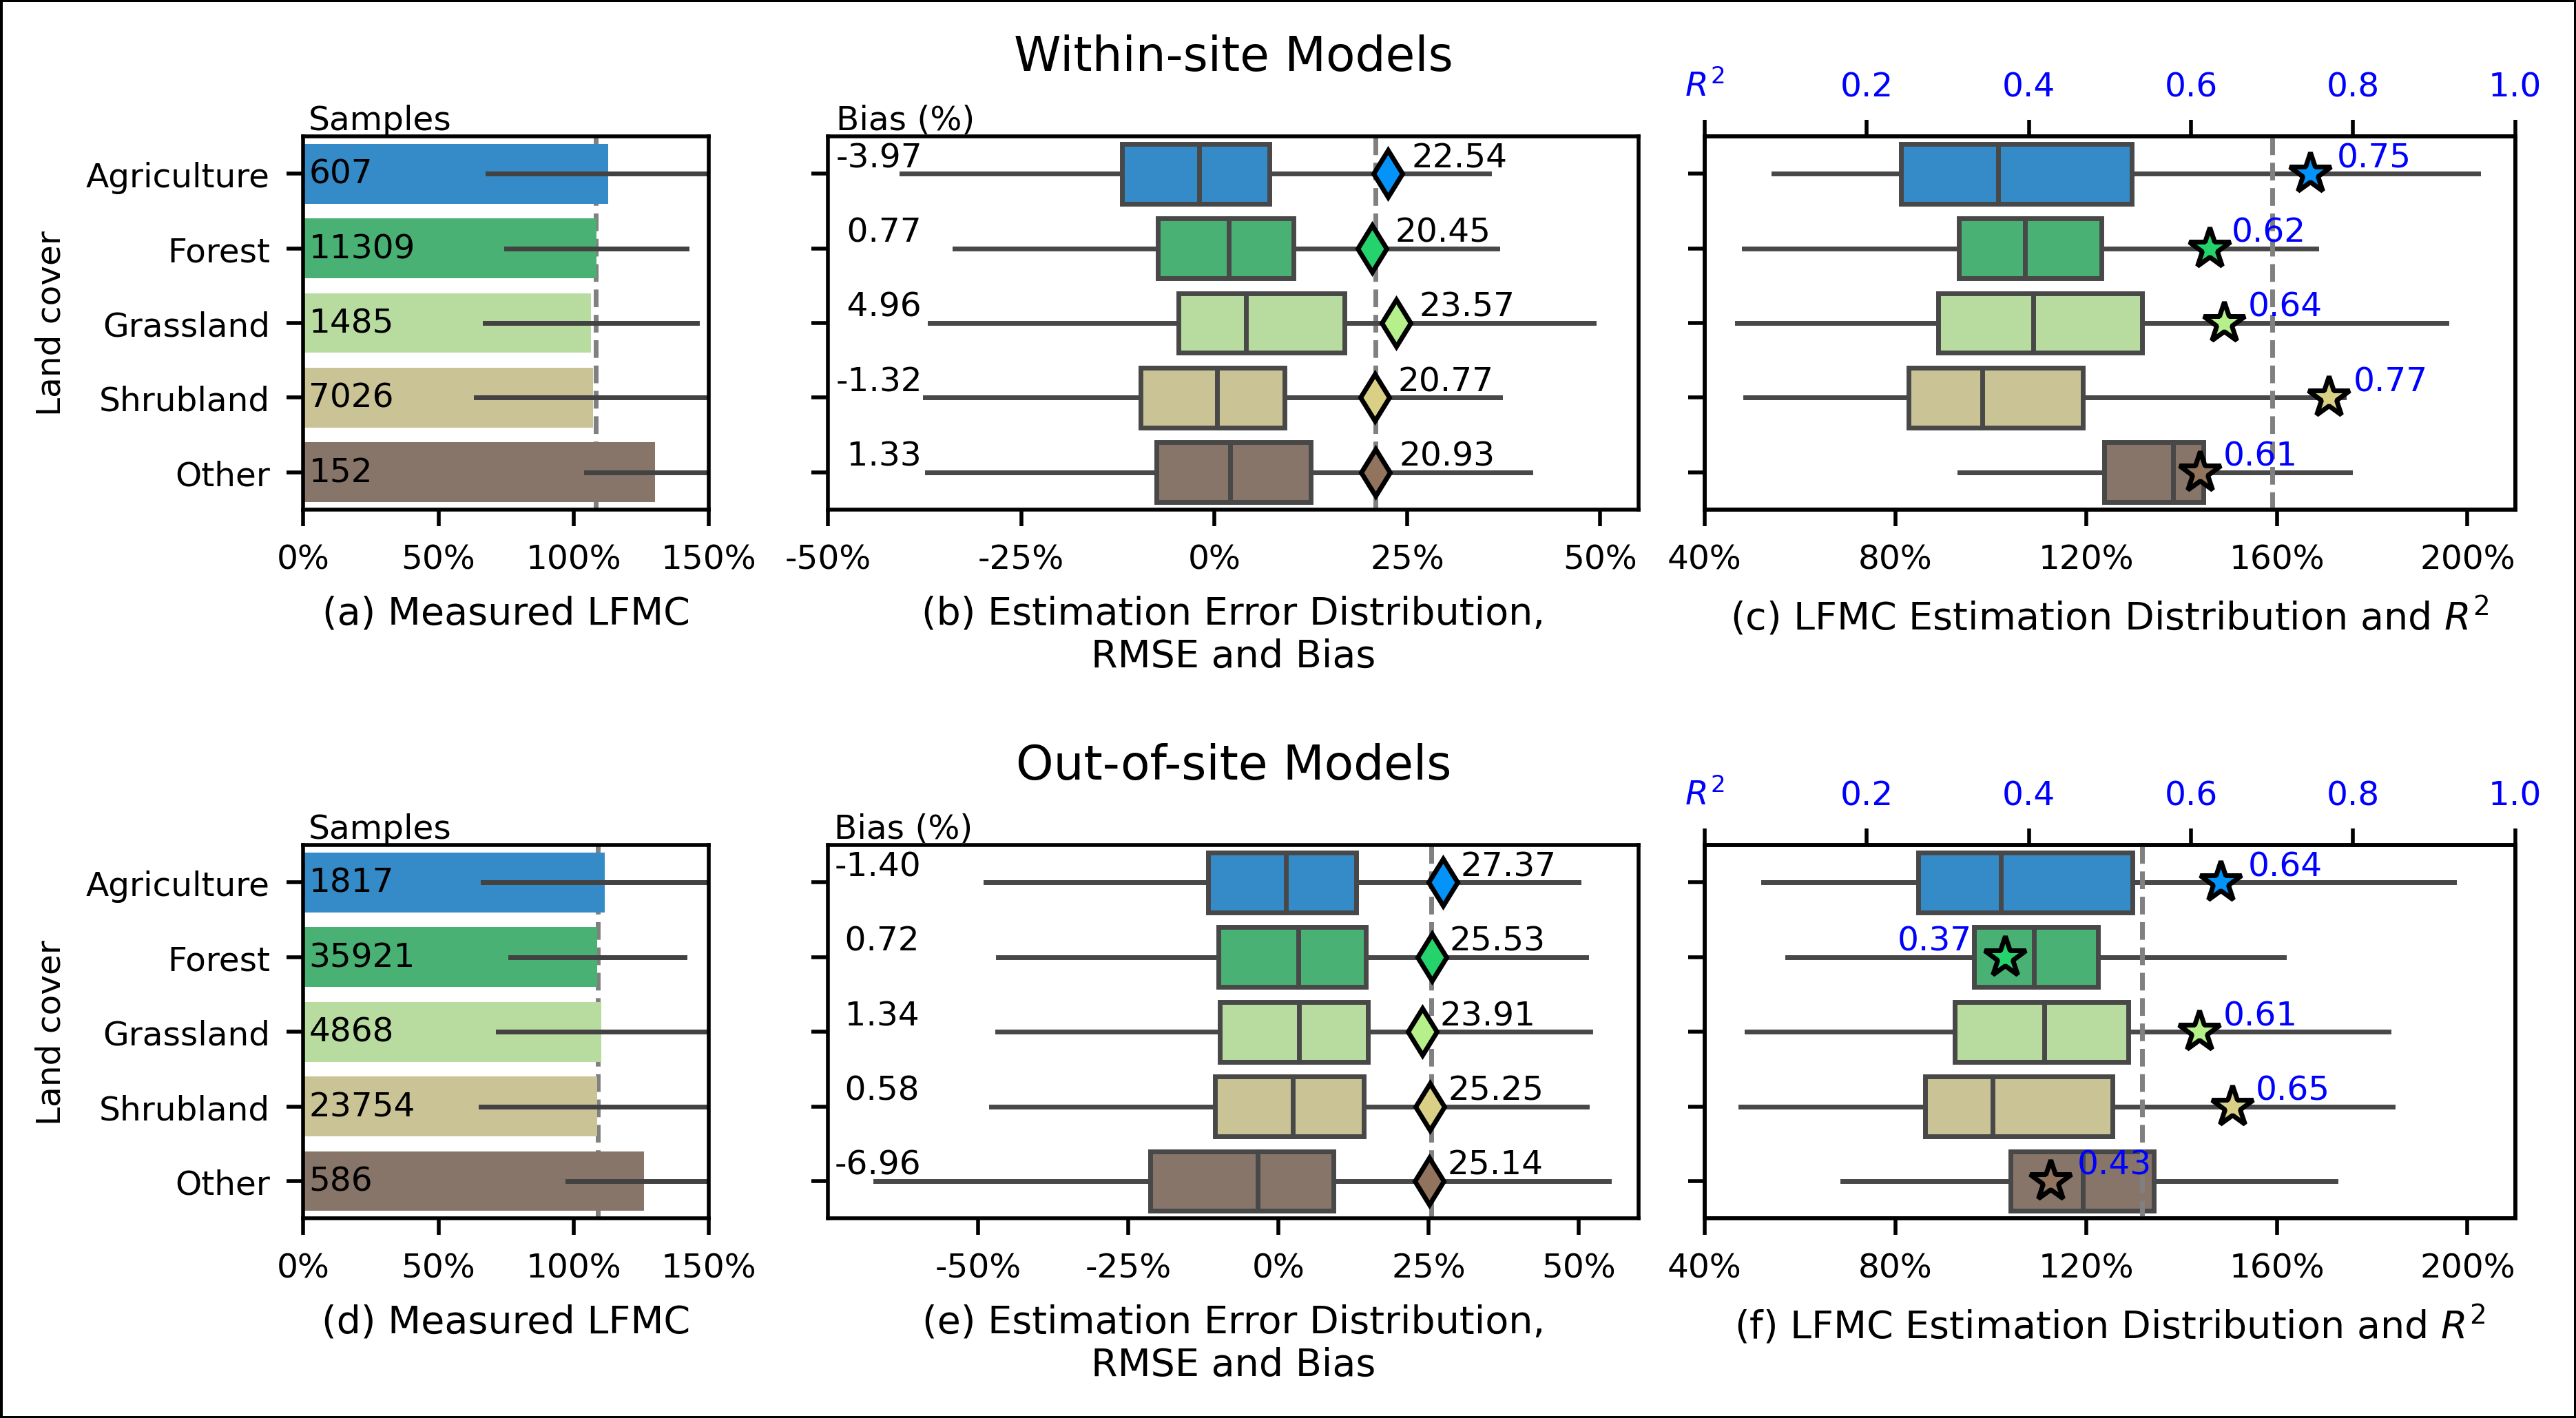

In [16]:
lc_labels = list(landcover_groups.keys())
sns.set_palette(sns.color_palette('terrain'))
plt.rcParams.update({'font.size': TEXT_SIZE})

xlim_lfmc = (0, 150)
xlim_rmse = (-50, 55)
xlim_r2 = (-0.5, 1.05)
xlim_pred = (40, 210)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    2, 3, figsize=(7.364, 4), gridspec_kw={'width_ratios': [1, 2, 2]},
    sharey=True, sharex=False,
    constrained_layout=True, dpi=500, linewidth=1, edgecolor="black")
fig.set_constrained_layout_pads(hspace=0.1)

ax1 = samples_plot_lc(lc1_plot_data, lc1_results['Samples'], ax1, 'a', xlim_lfmc)
ylim = ax1.get_ylim()
xline = samples1['LFMC value'].mean()
ax1.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, zorder=1)
ax1.set_ylim(ylim)
ax2 = plot_landcover(lc1_plot_data, lc1_results, ax2, xlim_rmse, ylim=ylim, xline=WITHIN_SITE_RMSE, label='b')
ax2.set_title(f'{DISPLAY_NAMES[0]}', y=1.1, fontsize=TITLE_SIZE)
ax3 = plot_landcover_r2(lc1_plot_data, lc1_results, ax3, xlim_pred, ylim=ylim, xline=WITHIN_SITE_R2, label='c')

xlim_lfmc = (0, 150)
xlim_rmse = (-75, 60)
xlim_r2 = (-0.5, 1.05)
xlim_pred = (40, 210)

ax4 = samples_plot_lc(lc2_plot_data, lc2_results['Samples'], ax4, 'd', xlim_lfmc)
ylim = ax4.get_ylim()
xline = all_samples['LFMC value'].mean()
ax4.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, zorder=1)
ax4.set_ylim(ylim)
ax5 = plot_landcover(lc2_plot_data, lc2_results, ax5, xlim_rmse, ylim=ylim, xline=OUT_OF_SITE_RMSE, label='e')
ax5.set_title(f'{DISPLAY_NAMES[1]}', y=1.1, fontsize=TITLE_SIZE)
ax6 = plot_landcover_r2(lc2_plot_data, lc2_results, ax6, xlim_pred, ylim=ylim, xline=OUT_OF_SITE_R2, label='f')

fig.savefig(os.path.join(output_dir, 'Land Cover.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.1, dpi=500)

### Landcover and Elevation Figure

In [17]:
def samples_plot_el(data, summ, ax, label, xlim):
    data = data.reset_index()
    data = data[data.Elevation.isin(labels) & data['Land cover'].isin(vars_)]
    sns.barplot(y=data['Elevation'], x=data['LFMC value'], hue=data['Land cover'], ci='sd',
                saturation=SATURATION, error_kw=dict(lw=LINE_WIDTH), ax=ax, zorder=2)
    for line in ax.lines:
        line.set_linewidth(LINE_WIDTH)
    ax.set_ylabel('Elevation')
    ax.set_xlabel(f'({label}) Measured LFMC', fontsize=FONT_SIZE)

    ng = len(vars_)
    ne = len(labels)
    for ytick in ax.get_yticks():
        for lc in range(ng):
            c = summ.loc[vars_[lc], labels[ytick]]
            y_off = ytick + [-0.267, 0.0, .267][lc]
            ax.text(2, y_off, c, va='center', size=TEXT_SIZE, zorder=3)
  
    ylim = ax1.get_ylim()
    xpos = 15 if label == 'a' else 2
    ax.text(xpos, ylim[1], 'Samples', va='bottom')

    ax.set_xlim(xlim)
    ax.set_xticks(range(xlim[0], xlim[1]+1, 50))
    ax.set_xticklabels([f'{i}%' for i in range(xlim[0], xlim[1]+1, 50)], fontsize=TEXT_SIZE)
    return ax

In [18]:
def plot_landcover_elevation(bp_data, lc_results, ax, xlim, xline, ylim, label):
    r1 = lc_results.reset_index()
    r1 = r1[r1.Elevation.isin(labels) & r1['Land Cover'].isin(vars_)]
    r1 = r1.set_index(['Elevation', 'Land Cover'])

    sns.boxplot(y='Elevation', x='Error', hue='Land cover', data=bp_data, order=labels,
                saturation=SATURATION, width=0.8, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2}, whiskerprops={'zorder': 2})

    bias = bp_data.groupby(['Elevation', 'Land cover']).Error.mean().round(2)
    ng = len(vars_)
    ne = len(labels)
    need_legend = True
    legend_points = []
    for ytick in ax.get_yticks():
        for lc in range(ng):
            y_off = ytick + [-0.267, 0.0, .267][lc]
            rmse = r1.RMSE.loc[labels[ytick], vars_[lc]]
            rmse_std = r1.RMSE_std.loc[labels[ytick], vars_[lc]]
            n_samples = r1.Samples.loc[labels[ytick], vars_[lc]]
            bias_ = bias.loc[labels[ytick], vars_[lc]]
            
            # Add the bias text
            t = ax.text(xlim[0]+1, y_off, f'{bias_: .2f}', ha='left', va='bottom', color='k', size=7)
            
            # Add the RMSE marker
            pt, = ax.plot(rmse, y_off, 'dk', markersize=7, scalex=False, zorder=3,
                          mfc=plt.rcParams["axes.prop_cycle"].by_key()["color"][lc])
            
            pos_ = round(rmse, 2) + 3
            rmse_text = f'{rmse:.2f}'
            t = ax.text(pos_, y_off, rmse_text, va='bottom', color='k', size=7)
            
    ax.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, zorder=1)
    ax.set_ylabel(None)
    ax.set_xlabel(f'({label}) Estimation Error Distribution,\nRMSE and Bias', fontsize=FONT_SIZE)
    ax.set_xlim(xlim)
    ax.set_xticks(range(-50, 71, 25))
    ax.set_xticklabels([f'{i}%' for i in range(-50, 71, 25)], fontsize=TEXT_SIZE)
    ax.text(xlim[0]+1, ylim[1], 'Bias (%)', va='bottom')
    return ax, legend_points

In [19]:
def plot_landcover_elevation_r2(bp_data, lc_results, ax, xlim, xline, ylim, label):
    r1 = lc_results.reset_index()
    r1 = r1[r1.Elevation.isin(labels) & r1['Land Cover'].isin(vars_)]
    r1 = r1.set_index(['Elevation', 'Land Cover'])

    sns.boxplot(y='Elevation', x='Estimated LFMC', hue='Land cover', data=bp_data, order=labels,
                saturation=SATURATION, width=0.8, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2}, whiskerprops={'zorder': 2})
    ax.set_xlabel(f'({label}) LFMC Estimation Distribution and $R^2$', fontsize=FONT_SIZE)
    ax.set_xlim(xlim)
    ax.set_xticks(range(40, xlim[1]+1, 40))
    ax.set_xticklabels([f'{i}%' for i in range(40, xlim[1]+1, 40)], fontsize=TEXT_SIZE)
    ax.set_ylabel(None)

    ax1=ax.twiny()
    ax1.set_xlim([0, 1])
    plt.setp(ax1.get_xticklabels(), color="blue")
    ax1.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, zorder=1)

    ng = len(vars_)
    ne = len(labels)
    need_legend = True
    legend_points = []
    for ytick in ax.get_yticks():
        for lc in range(ng):
            y_off = ytick + [-0.267, 0.0, .267][lc]
            r2 = r1.R2.loc[labels[ytick], vars_[lc]]
            r2_std = r1.R2_std.loc[labels[ytick], vars_[lc]]
            
            # Add the R2 marker
            pt, = ax1.plot(r2, y_off, '*k', markersize=9, scalex=False,
                          mfc=plt.rcParams["axes.prop_cycle"].by_key()["color"][lc])
            
            # Add the R2 text
            pos_ = round(r2, 2)
            r2_text = f'{r2:.2f}' #'\n$\pm${r2_std:.2f}' 
            ha = 'right' if r2 < 0.4 else 'left'
            pos_ = (pos_ - 0.04) if r2 < 0.4 else (pos_ + 0.03)
            t = ax1.text(pos_, y_off, r2_text, va='bottom', ha=ha, color='b', size=7)

    ax1.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax1.set_xticklabels(['$R^2$', 0.2, 0.4, 0.6, 0.8, 1.0])
    return ax, legend_points

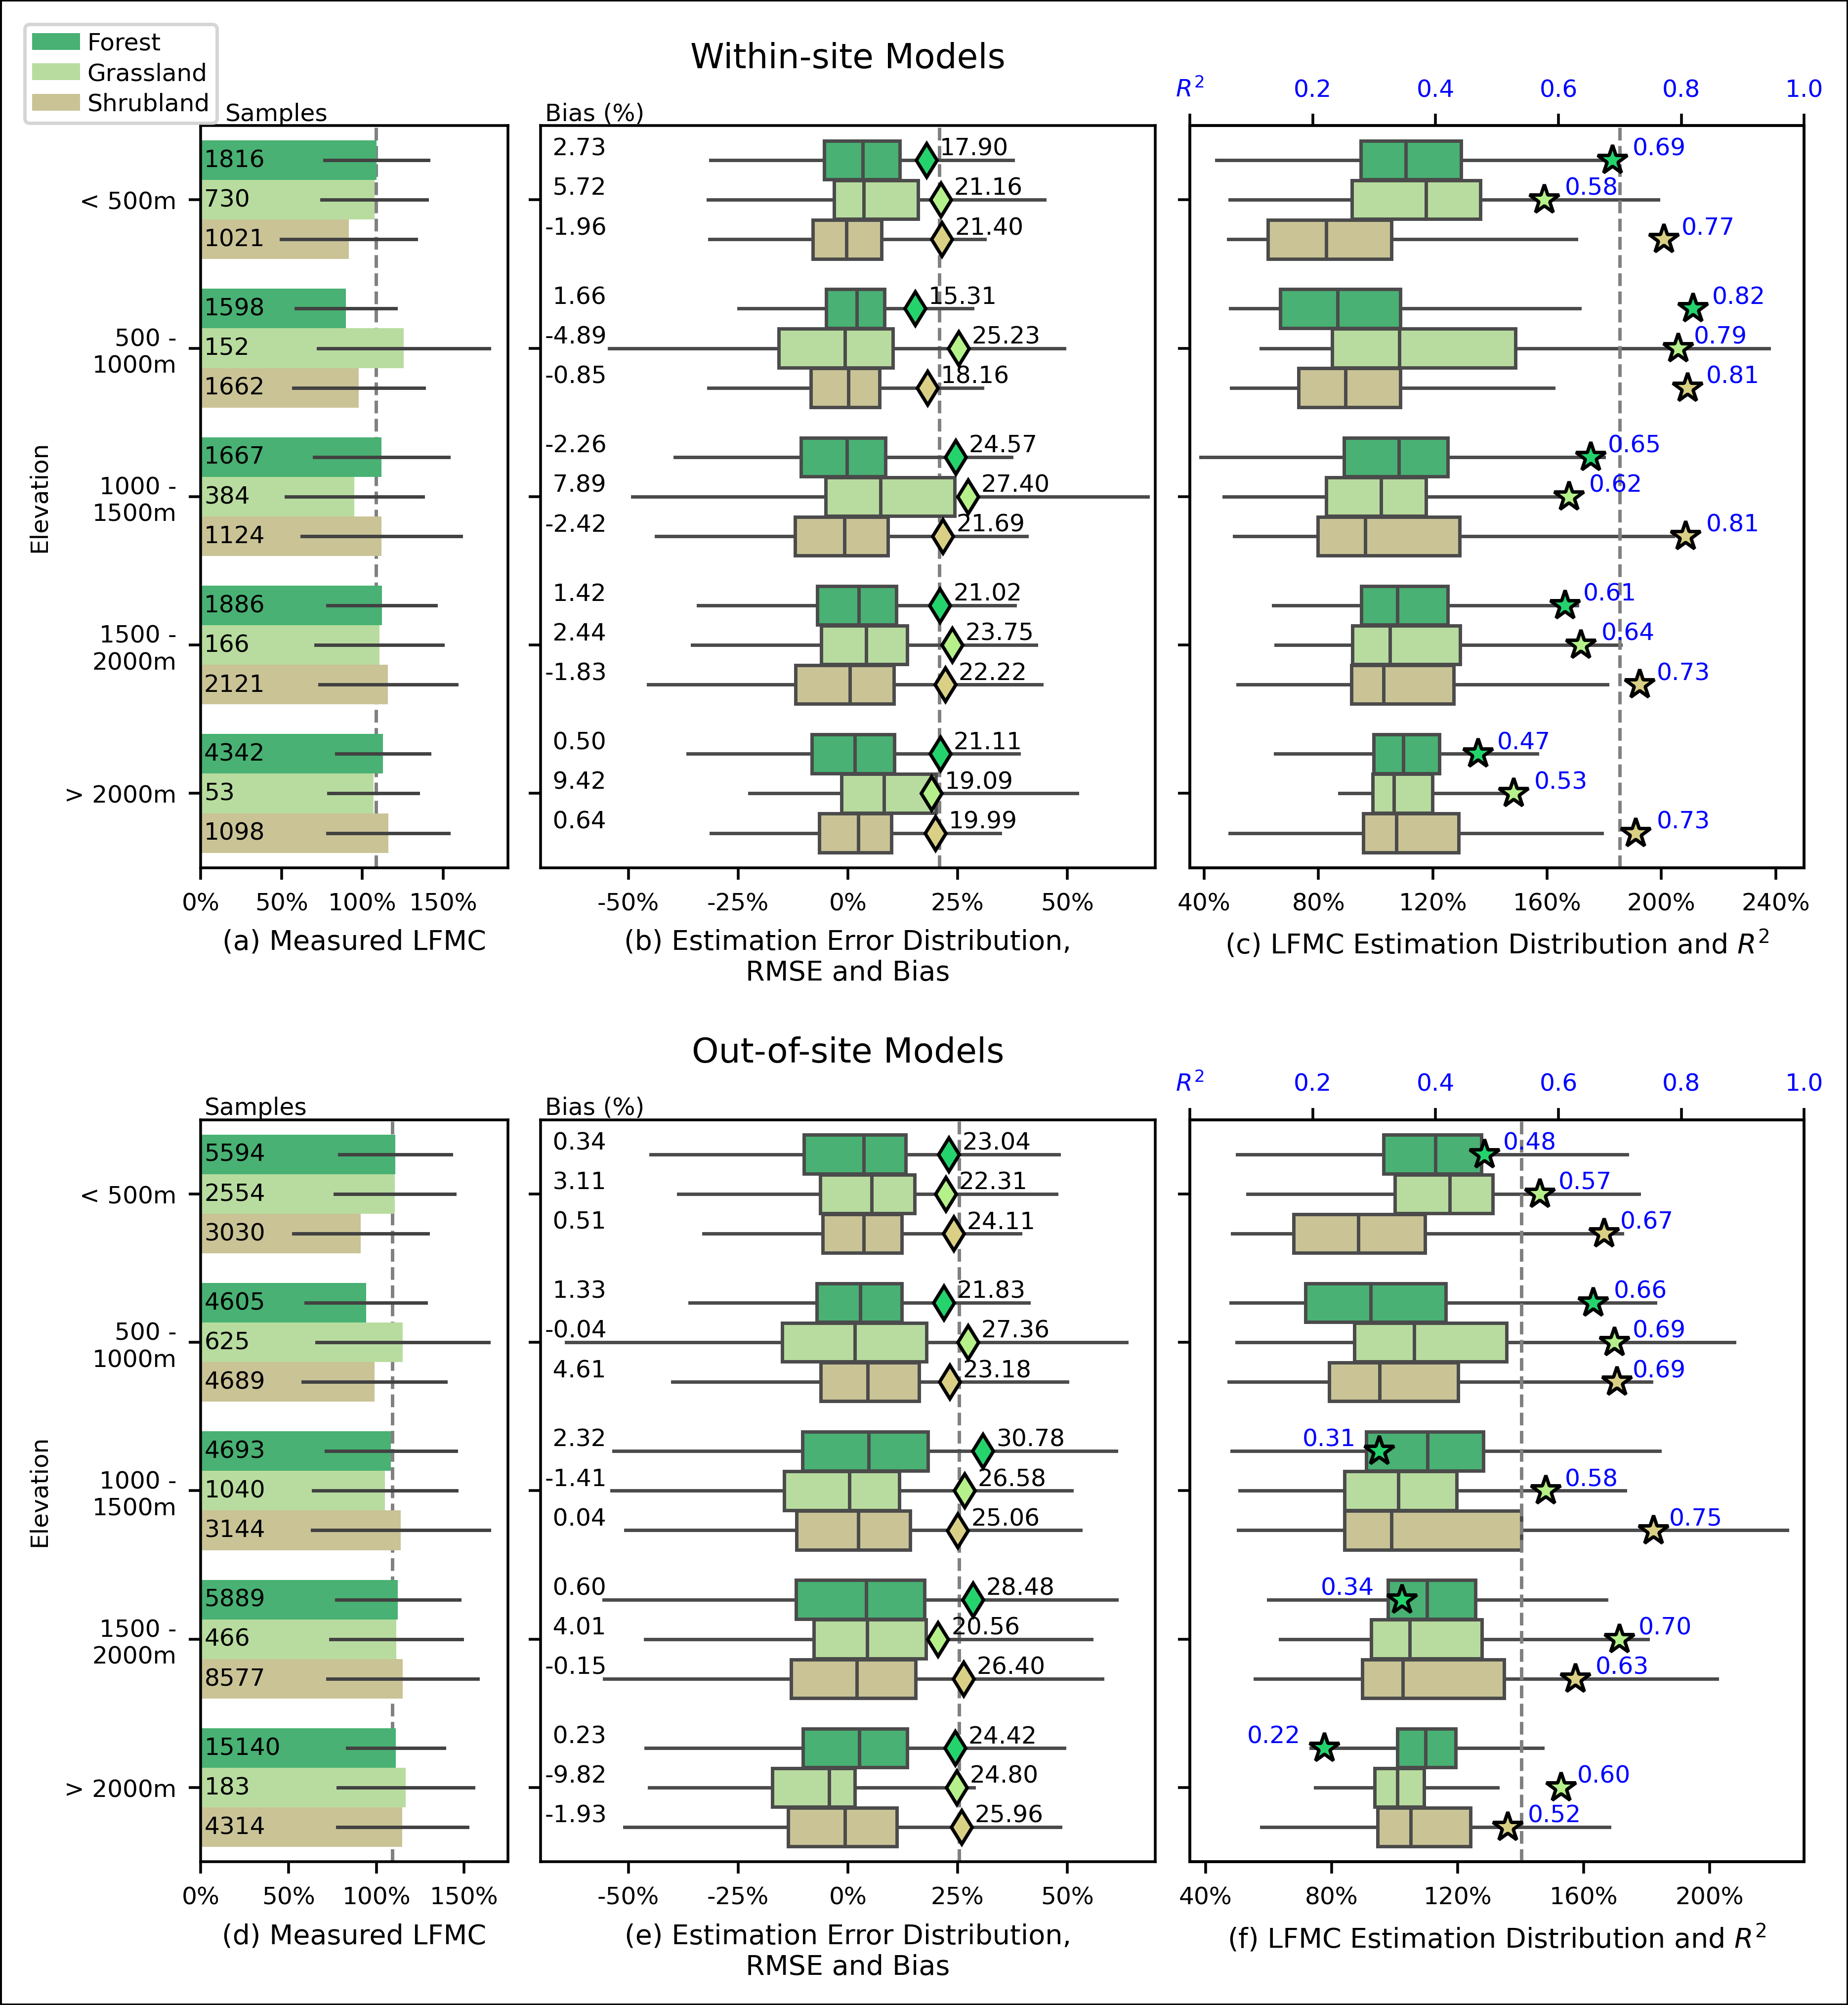

In [20]:
labels = list(elevation_groups.keys())
vars_ = list(landcover_groups.keys())[1:-1]

xlim_lfmc = (0, 190)
xlim_rmse = (-70, 70)
xlim_r2 = (-0.5, 1.05)
xlim_pred = (35, 250)

plt.rcParams.update({'font.size': TEXT_SIZE})
sns.set_palette(sns.color_palette('terrain')[1:])
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    2, 3, figsize=(7.364, 8), gridspec_kw={'width_ratios': [1, 2, 2]},
    sharey=True, sharex=False,
    constrained_layout=True, dpi=500, linewidth=1, edgecolor="black")
fig.set_constrained_layout_pads(hspace=0.05)

ax1 = samples_plot_el(lc3_plot_data, lc3_results['Samples'], ax=ax1, label='a', xlim=xlim_lfmc)
ylim = ax1.get_ylim()
xline = samples1['LFMC value'].mean()
ax1.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, zorder=1)
ax1.set_ylim(ylim)

ax2, legend_points1 = plot_landcover_elevation(lc3_plot_data, lc3_results, ax2, xlim_rmse, ylim=ylim, xline=WITHIN_SITE_RMSE, label='b')
ax2.set_title(f'{DISPLAY_NAMES[0]}', y=1.05, fontsize=TITLE_SIZE)

bp_data3 = lc3_plot_data.reset_index().merge(predict1.stack().rename('Estimated LFMC').reset_index())
ax3, legend_points2 = plot_landcover_elevation_r2(lc3_plot_data, lc3_results, ax3, xlim_pred, ylim=ylim, xline=WITHIN_SITE_R2, label='c')

xlim_lfmc = (0, 175)
xlim_rmse = (-70, 70)
xlim_r2 = (-0.5, 1.05)
xlim_pred = (35, 230)

ax4 = samples_plot_el(lc4_plot_data, lc4_results['Samples'], ax=ax4, label='d', xlim=xlim_lfmc)
ylim = ax4.get_ylim()
xline = all_samples['LFMC value'].mean()
ax4.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, zorder=1)

ax5, legend_points3 = plot_landcover_elevation(lc4_plot_data, lc4_results, ax5, xlim_rmse, ylim=ylim, xline=OUT_OF_SITE_RMSE, label='e')
ax5.set_title(f'{DISPLAY_NAMES[1]}', y=1.05, fontsize=TITLE_SIZE)

bp_data4 = lc4_plot_data.reset_index().merge(predict2.stack().rename('Estimated LFMC').reset_index())
ax6, legend_points4 = plot_landcover_elevation_r2(lc4_plot_data, lc4_results, ax6, xlim_pred, ylim=ylim, xline=OUT_OF_SITE_R2, label='f')

ax1.set_yticklabels([l.replace('-', ' -\n') for l in labels])
ax1.yaxis.label_pad = 0.0
ax1.legend(loc='center', bbox_to_anchor=(-0.26, 1.07), labelspacing=0.3, borderpad=0.3, handletextpad=0.3)
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax6.get_legend().remove()

fig.savefig(os.path.join(output_dir, 'Land Cover Elevation.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.1, dpi=500)

### Fire Danger Threshold Figure

In [21]:
def threshold_results(y, yhat, threshold):
    counts = []
    total = y.count() / 100
    for i in yhat.columns:
        counts.append([(y.le(threshold) & yhat[i].le(threshold)).sum() / total,
                       (y.le(threshold) & yhat[i].gt(threshold)).sum() / total,
                       (y.gt(threshold) & yhat[i].le(threshold)).sum() / total,
                       (y.gt(threshold) & yhat[i].gt(threshold)).sum() / total])
    counts = pd.DataFrame(counts, columns=['High fire risk', 'Warning failures', 'False alarms', 'Low fire risk'])

    df = []
    for n, c in counts.items():
        df.append(pd.DataFrame([c.mean(), c.std()], index=['mean', 'std dev'], columns=[n]))
    return pd.concat(df, axis=1) #.round(2).astype(int)

In [22]:
def threshold_summary(samples1, predict1, samples2, predict2, threshold, ybar):
    results = [threshold_results(samples1, predict1, threshold), threshold_results(samples2, predict2, threshold)]

    r1 = []
    for c, i in predict1.items():
        samples_index = samples1.le(threshold)
        r1.append(calc_statistics(samples1[samples_index], i[samples_index], ybar[0]))

    r2 = []
    for c, i in predict2.items():
        samples_index = samples2.le(threshold)
        r2.append(calc_statistics(samples2[samples_index], i[samples_index], ybar[1]))

    means = pd.concat([pd.DataFrame(r1), pd.DataFrame(r2)], axis=1, keys=DISPLAY_NAMES).mean().unstack()
    stds = pd.concat([pd.DataFrame(r1), pd.DataFrame(r2)], axis=1, keys=DISPLAY_NAMES).std().unstack()
    rmse120 = pd.DataFrame([means.RMSE, stds.RMSE, means.Bias, stds.Bias, means.R2, stds.R2],
                           index=['RMSE mean', 'RMSE std', 'Bias mean', 'Bias std', 'R2 mean', 'R2 std']).round(2)
    results.append(rmse120)

    display_frames([r.T for r in results], DISPLAY_NAMES + [f'LFMC < {threshold}'])
    return results

In [23]:
ybar = (samples1['LFMC value'].mean(), all_samples['LFMC value'].mean())
counts = [{}, {}]
data1 = lc1_plot_data[(lc1_plot_data['Land cover'] == 'Forest')]['LFMC value'].reset_index().drop_duplicates().set_index(['ID'])['LFMC value']
data2 = lc1_plot_data[(lc1_plot_data['Land cover'] == 'Forest')][['Estimated LFMC', 'Model']].pivot(columns=['Model'])
data3 = lc2_plot_data[(lc2_plot_data['Land cover'] == 'Forest')]['LFMC value'].reset_index().drop_duplicates().set_index(['ID'])['LFMC value']
data4 = lc2_plot_data[(lc2_plot_data['Land cover'] == 'Forest')][['Estimated LFMC', 'Model']].pivot(columns=['Model'])
threshold = 105
counts[0]['Forest'] = [(data1 <= threshold).sum(), (data1 > threshold).sum(), threshold]
counts[1]['Forest'] = [(data3 <= threshold).sum(), (data3 > threshold).sum(), threshold]
forest = threshold_summary(data1, data2, data3, data4, threshold, ybar)

Within-site Models 
 
 
   
 mean 
 std dev 
 
 
 
 
 High fire risk 
 39.617 
 0.141 
 
 
 Warning failures 
 11.864 
 0.141 
 
 
 False alarms 
 6.524 
 0.127 
 
 
 Low fire risk 
 41.995 
 0.127 
 
 
 
          
 
 Out-of-site Models 
 
 
   
 mean 
 std dev 
 
 
 
 
 High fire risk 
 33.194 
 0.172 
 
 
 Warning failures 
 18.982 
 0.172 
 
 
 False alarms 
 8.321 
 0.137 
 
 
 Low fire risk 
 39.503 
 0.137 
 
 
 
          
 
 LFMC < 105 
 
 
   
 RMSE mean 
 RMSE std 
 Bias mean 
 Bias std 
 R2 mean 
 R2 std 
 
 
 
 
 Within-site Models 
 17.140 
 0.080 
 8.160 
 0.100 
 0.640 
 0.000 
 
 
 Out-of-site Models 
 20.990 
 0.090 
 12.700 
 0.150 
 0.400 
 0.010

In [24]:
data1 = lc1_plot_data[(lc1_plot_data['Land cover'] == 'Grassland')]['LFMC value'].reset_index().drop_duplicates().set_index(['ID'])['LFMC value']
data2 = lc1_plot_data[(lc1_plot_data['Land cover'] == 'Grassland')][['Estimated LFMC', 'Model']].pivot(columns=['Model'])
data3 = lc2_plot_data[(lc2_plot_data['Land cover'] == 'Grassland')]['LFMC value'].reset_index().drop_duplicates().set_index(['ID'])['LFMC value']
data4 = lc2_plot_data[(lc2_plot_data['Land cover'] == 'Grassland')][['Estimated LFMC', 'Model']].pivot(columns=['Model'])
threshold = 67
counts[0]['Grassland'] = [(data1 <= threshold).sum(), (data1 > threshold).sum(), threshold]
counts[1]['Grassland'] = [(data3 <= threshold).sum(), (data3 > threshold).sum(), threshold]
grassland = threshold_summary(data1, data2, data3, data4, threshold, ybar)

Within-site Models 
 
 
   
 mean 
 std dev 
 
 
 
 
 High fire risk 
 8.974 
 0.144 
 
 
 Warning failures 
 7.794 
 0.144 
 
 
 False alarms 
 0.844 
 0.070 
 
 
 Low fire risk 
 82.388 
 0.070 
 
 
 
          
 
 Out-of-site Models 
 
 
   
 mean 
 std dev 
 
 
 
 
 High fire risk 
 5.795 
 0.259 
 
 
 Warning failures 
 7.475 
 0.259 
 
 
 False alarms 
 1.031 
 0.048 
 
 
 Low fire risk 
 85.698 
 0.048 
 
 
 
          
 
 LFMC < 67 
 
 
   
 RMSE mean 
 RMSE std 
 Bias mean 
 Bias std 
 R2 mean 
 R2 std 
 
 
 
 
 Within-site Models 
 24.720 
 0.290 
 15.250 
 0.260 
 0.780 
 0.010 
 
 
 Out-of-site Models 
 23.870 
 0.210 
 16.650 
 0.320 
 0.800 
 0.000

In [25]:
data1 = lc1_plot_data[(lc1_plot_data['Land cover'] == 'Shrubland')]['LFMC value'].reset_index().drop_duplicates().set_index(['ID'])['LFMC value']
data2 = lc1_plot_data[(lc1_plot_data['Land cover'] == 'Shrubland')][['Estimated LFMC', 'Model']].pivot(columns=['Model'])
data3 = lc2_plot_data[(lc2_plot_data['Land cover'] == 'Shrubland')]['LFMC value'].reset_index().drop_duplicates().set_index(['ID'])['LFMC value']
data4 = lc2_plot_data[(lc2_plot_data['Land cover'] == 'Shrubland')][['Estimated LFMC', 'Model']].pivot(columns=['Model'])
threshold = 121
counts[0]['Shrubland'] = [(data1 <= threshold).sum(), (data1 > threshold).sum(), threshold]
counts[1]['Shrubland'] = [(data3 <= threshold).sum(), (data3 > threshold).sum(), threshold]
shrubland = threshold_summary(data1, data2, data3, data4, threshold, ybar)

Within-site Models 
 
 
   
 mean 
 std dev 
 
 
 
 
 High fire risk 
 69.910 
 0.094 
 
 
 Warning failures 
 3.888 
 0.094 
 
 
 False alarms 
 6.163 
 0.094 
 
 
 Low fire risk 
 20.040 
 0.094 
 
 
 
          
 
 Out-of-site Models 
 
 
   
 mean 
 std dev 
 
 
 
 
 High fire risk 
 65.020 
 0.098 
 
 
 Warning failures 
 7.208 
 0.098 
 
 
 False alarms 
 7.036 
 0.066 
 
 
 Low fire risk 
 20.737 
 0.066 
 
 
 
          
 
 LFMC < 121 
 
 
   
 RMSE mean 
 RMSE std 
 Bias mean 
 Bias std 
 R2 mean 
 R2 std 
 
 
 
 
 Within-site Models 
 14.500 
 0.070 
 3.320 
 0.150 
 0.750 
 0.000 
 
 
 Out-of-site Models 
 19.360 
 0.100 
 7.710 
 0.180 
 0.550 
 0.010

In [26]:
def fmt_label(mean_, std_):
    return f'{mean_:.1f}%$\pm${std_:.1f}'

def make_autopct(df):
    def my_autopct(pct):
        std = df[np.round(df['mean'],2) == np.round(pct,2)]['std dev']
        return fmt_label(pct, std[0])
    return my_autopct

In [27]:
bar_order = ['High fire risk', 'Warning failures', 'False alarms', 'Low fire risk']
lc_keys = ['Forest', 'Grassland', 'Shrubland']
temp = {'Forest': forest, 'Grassland': grassland, 'Shrubland': shrubland}
plot_data = {
    DISPLAY_NAMES[0]: {k: [counts[0][k][2], temp[k][0].T, temp[k][2][DISPLAY_NAMES[0]]] for k in lc_keys},
    DISPLAY_NAMES[1]: {k: [counts[1][k][2], temp[k][1].T, temp[k][2][DISPLAY_NAMES[1]]] for k in lc_keys}
}

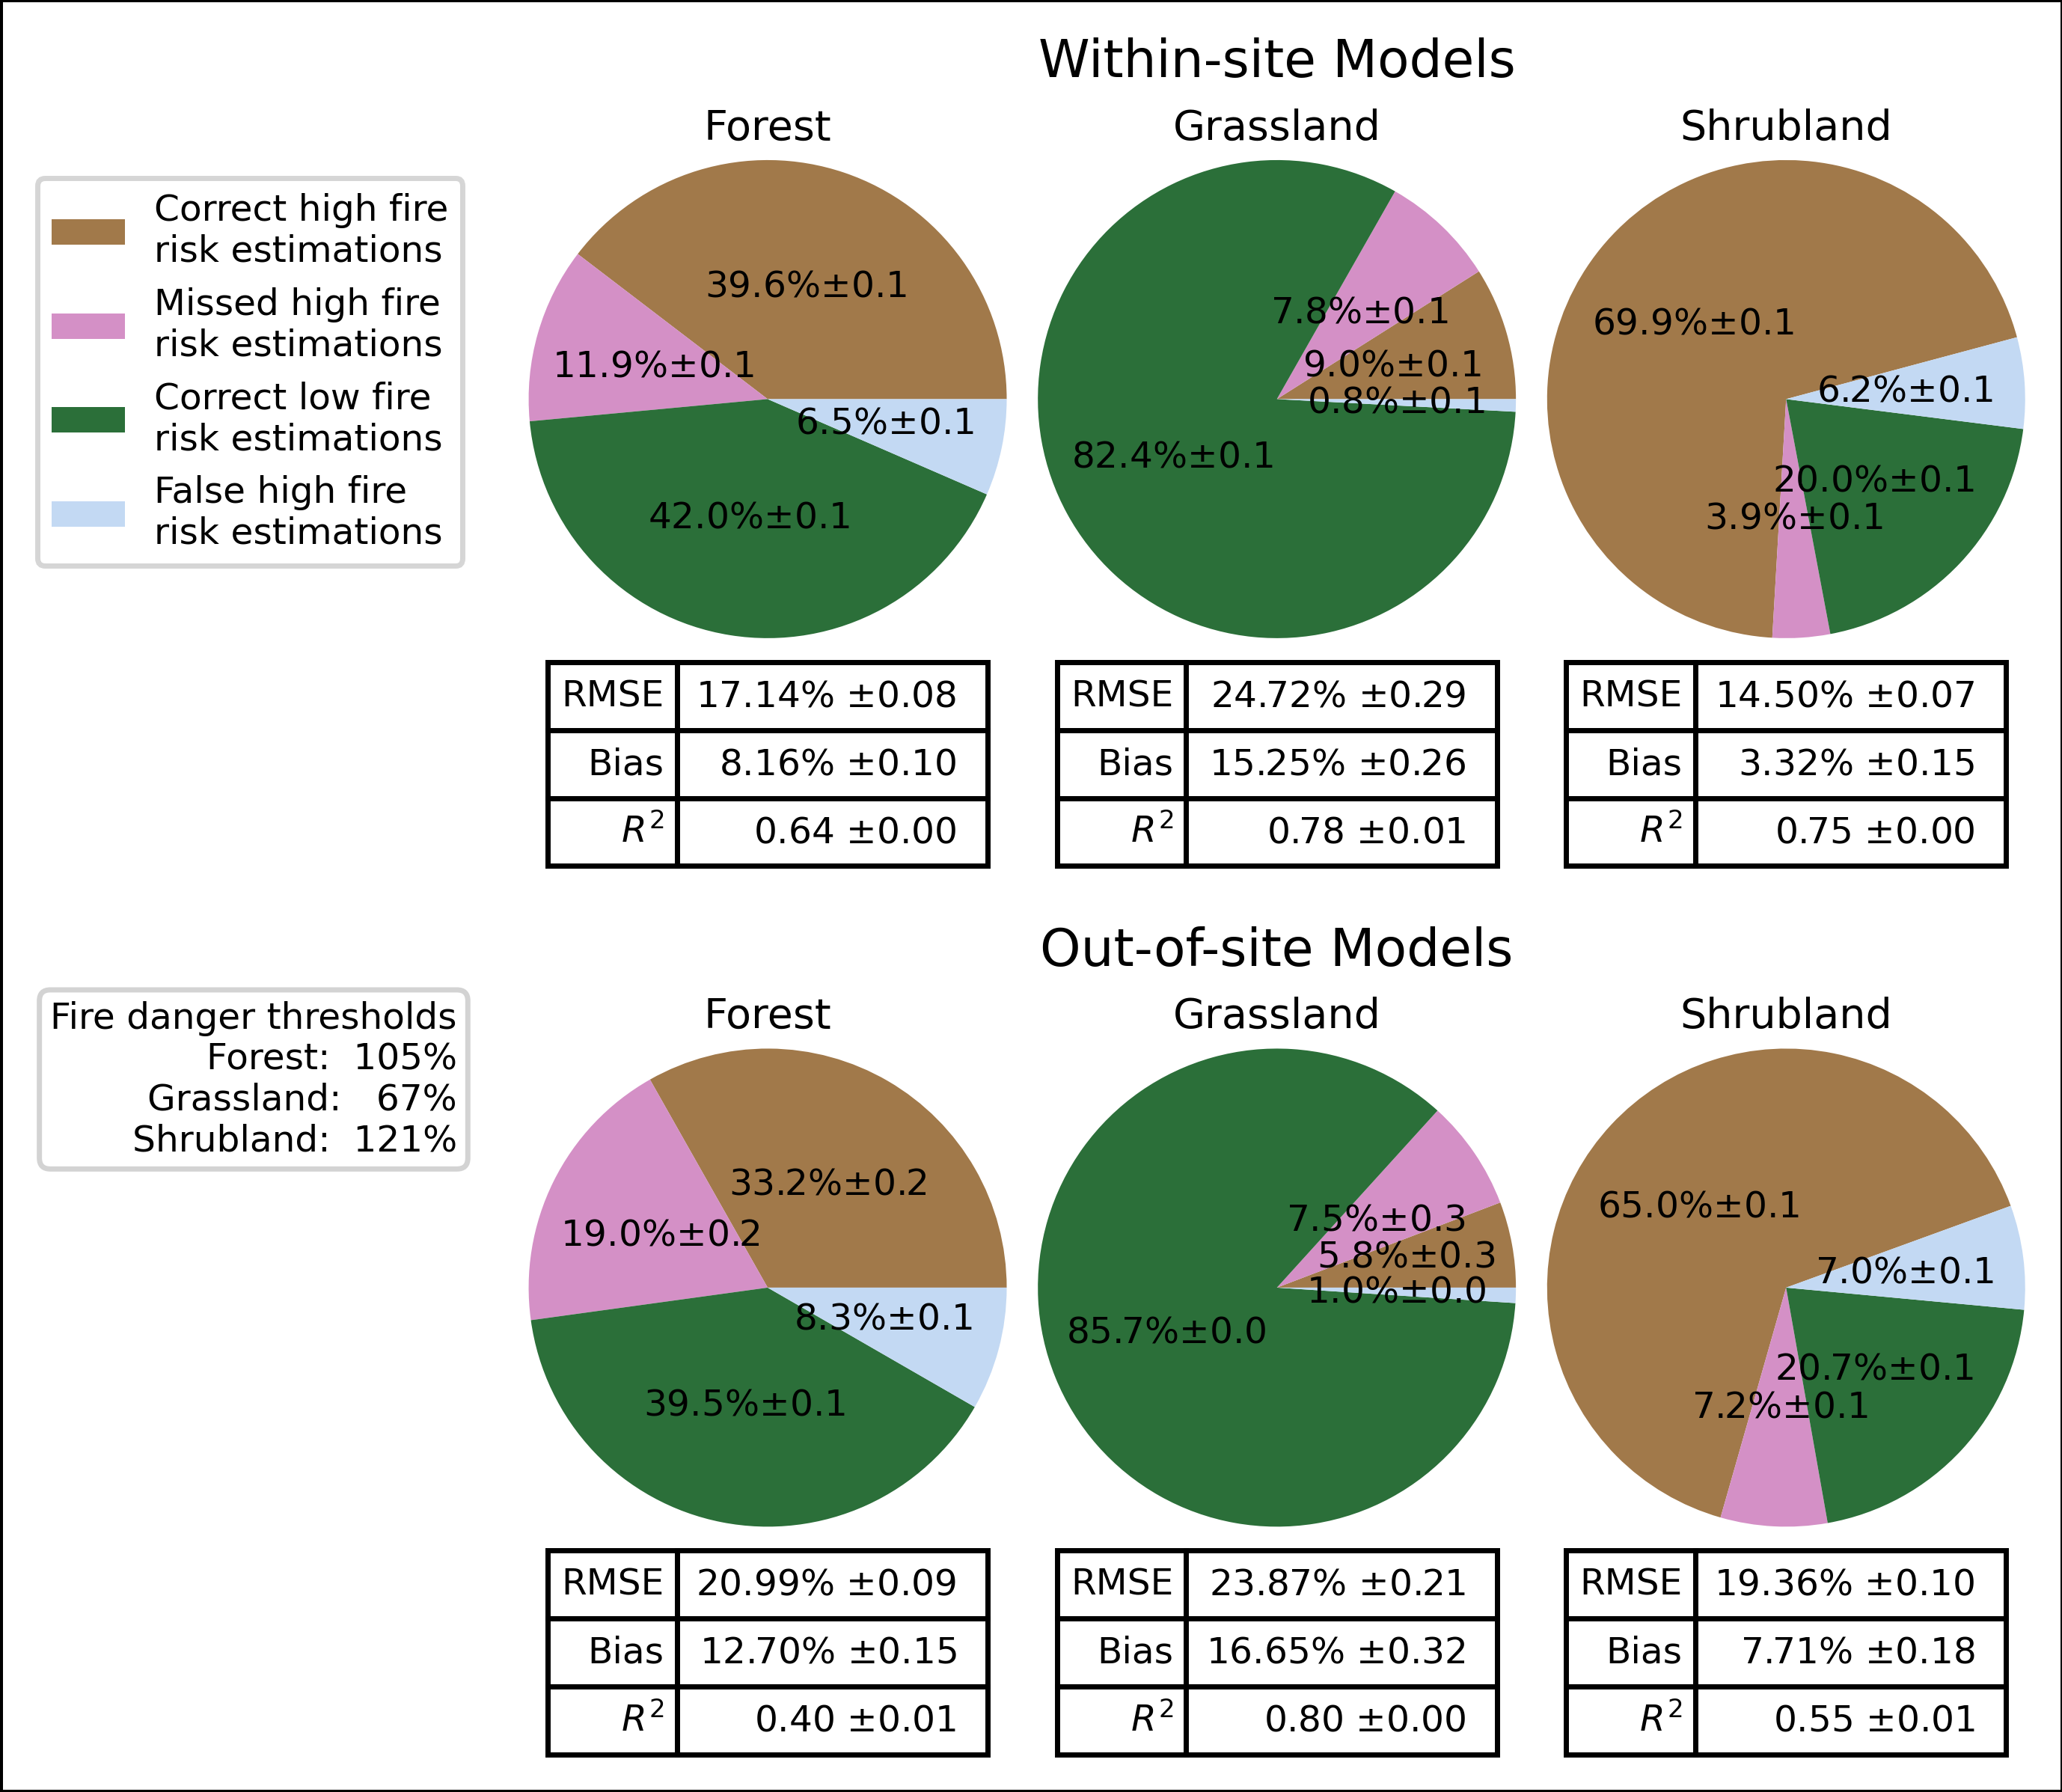

In [28]:
palette = sns.color_palette('cubehelix', 5)[1:]
colours = [palette[1], palette[2], palette[0], palette[3]]
sns.set_palette(colours)
lc_keys = ['Forest', 'Grassland', 'Shrubland']
pie_order = ['High fire risk', 'Warning failures', 'Low fire risk', 'False alarms']
pie_labels = ['Correct high fire\nrisk estimations', 'Missed high fire\nrisk estimations',
              'Correct low fire\nrisk estimations', 'False high fire\nrisk estimations']
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    2, 3, figsize=(5.397, 4.75), sharey=False, sharex=False,  #7.346, 6.5      5.5, 4.5
    constrained_layout=True, dpi=500, linewidth=1, edgecolor="black")

df1 = pd.concat([forest[0].T['mean'], grassland[0].T['mean'], shrubland[0].T['mean']], keys=lc_keys).unstack()
df1a = pd.concat([forest[2]['Within-site Models'], grassland[2]['Within-site Models'], shrubland[2]['Within-site Models']], axis=1, keys=lc_keys)
for idx, ax in enumerate([ax1, ax2, ax3]):
    lc_key = lc_keys[idx]
    sa = 15 if idx == 2 else 0
    df = plot_data[DISPLAY_NAMES[0]][lc_key][1]
    df1[pie_order].loc[lc_key].plot.pie(
        ax=ax, colors=colours, autopct=make_autopct(df),
        labels=['', '', '', ''], startangle=sa, pctdistance=0.5, radius=1)
    if idx == 1:
        ax.set_title(f"{DISPLAY_NAMES[0]}", fontsize=10)
    ax.set_ylabel('')
    ax.set_xlabel(lc_key, fontsize=8)    
    ax.xaxis.set_label_position('top')
    ax.set_xlim((-1.0,1.0))
    ax.set_ylim((-1.1,1.0))
    df_ = df1a[lc_key]
    values_ = [['RMSE', f"{df_['RMSE mean']:.2f}% $\pm${df_['RMSE std']:.2f}"],
               ['Bias', f"{df_['Bias mean']:.2f}% $\pm${df_['Bias std']:.2f}"],
               ['$R^2$', f"{df_['R2 mean']:.2f} $\pm${df_['R2 std']:.2f}"]]
    tab_ = ax.table(cellText=values_, loc='bottom', fontsize=TEXT_SIZE, colWidths=[0.27, 0.65])
    tab_.auto_set_font_size(False)

df2 = pd.concat([forest[1].T['mean'], grassland[1].T['mean'], shrubland[1].T['mean']], keys=['Forest', 'Grassland', 'Shrubland']).unstack()
df2a = pd.concat([forest[2]['Out-of-site Models'], grassland[2]['Out-of-site Models'], shrubland[2]['Out-of-site Models']], axis=1, keys=lc_keys)
for idx, ax in enumerate([ax4, ax5, ax6]):
    lc_key = lc_keys[idx]
    pd_ = plot_data[DISPLAY_NAMES[1]]
    sa = 20 if idx == 2 else 0
    df = plot_data[DISPLAY_NAMES[1]][lc_key][1]
    df2[pie_order].loc[lc_key].plot.pie(
        ax=ax, colors=colours, autopct=make_autopct(df), # autopct='%1.1f%%',
        labels=['', '', '', ''], startangle=sa, pctdistance=0.5, radius=1)
    if idx == 1:
        ax.set_title(f"{DISPLAY_NAMES[1]}", fontsize=10)
        text_str = fmt_label(*list(plot_data['Out-of-site Models'][lc_key][1].loc[pie_order[0]]))
        for child in ax.get_children():
            if isinstance(child, plt.Text) and child.get_text() == text_str:
                x_pos, y_pos = child.get_position()
                y_pos = y_pos + 0.04
                x_pos = x_pos + 0.05
                child.set_y(y_pos)
                child.set_x(x_pos)
                break
    ax.set_ylabel('')
    ax.set_xlabel(lc_key, fontsize=8)    
    ax.xaxis.set_label_position('top')
    ax.set_xlim((-1.0,1.0))
    ax.set_ylim((-1.1,1.0))
    df_ = df2a[lc_key]
    values_ = [['RMSE', f"{df_['RMSE mean']:.2f}% $\pm${df_['RMSE std']:.2f}"],
               ['Bias', f"{df_['Bias mean']:.2f}% $\pm${df_['Bias std']:.2f}"],
               ['$R^2$', f"{df_['R2 mean']:.2f} $\pm${df_['R2 std']:.2f}"]]
    tab_ = ax.table(cellText=values_, loc='bottom', fontsize=TEXT_SIZE, colWidths=[0.27, 0.65])
    tab_.auto_set_font_size(False)

ax1.legend(labels=pie_labels, bbox_to_anchor=(-0.10, 1.0))
ax4.text(-1.3, 1.2, "Fire danger thresholds\n" + "\n".join([f"{lc}: {th[2]:4d}%" for lc, th in counts[0].items()]),
         va='top', ha='right', bbox=dict(boxstyle='round,pad=0.3', facecolor='none', edgecolor='lightgrey'))

fig.savefig(os.path.join(output_dir, 'LFMC thresholds.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.1, dpi=500)